## Imports

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from textwrap import wrap

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

sns.set_theme(style="darkgrid", palette="colorblind")
sns.set(rc={"figure.figsize": (11.5, 8.5), "figure.dpi": 100})

from utils.data_profiling import band_proportions_periodic, sns_multi_time_series, topn_icd_in_year, sci_subset, median_los_per_band

%load_ext autoreload
%autoreload 1
%aimport utils.data_profiling

In [2]:
class Notebook:
    FIGSIZE_SMALL = (6, 5)
    FIGSIZE_LARGE = (11.5, 8.5)


In [3]:
# Read dataset files
ad = pd.read_hdf("data/ad.h5", "table")
sci = pd.read_hdf("data/sci.h5", "table")
icd10 = pd.read_hdf("data/icd10.h5", "ICD10_3_Codes")
birk = pd.read_hdf("data/birkmeyer_icd10.h5", "table")



In [4]:
icd10_chapter_dict = (
    icd10[["Chapter_No", "Chapter_Desc"]]
    .set_index("Chapter_No")
    .drop_duplicates()
    .Chapter_Desc.to_dict()
)
icd10_group_dict = (
    icd10[["Group_Code", "Group_Desc"]]
    .set_index("Group_Code")
    .drop_duplicates()
    .Group_Desc.to_dict()
)


In [5]:
def join_icd10(df, icd10):
    # Extract ICD10 3-code and join with ICD10 table to get corresponding group and chapter per ICD10 code
    df["MainICD10_3_Code"] = df.MainICD10.str[:3]
    return df.merge(icd10, left_on="MainICD10_3_Code", right_index=True)


sci, ad = join_icd10(sci, icd10), join_icd10(ad, icd10)



In [6]:
def join_birk(df, birk):
    return df .join(
        birk.drop_duplicates('ICD10Code_Closest').set_index('ICD10Code_Closest'), 
        how='inner', on='MainICD10'
    )

sci_birk, ad_birk = \
    join_birk(sci, birk), join_birk(ad, birk)

# SCI Dataset

## Admission Statistics

In [7]:
def total_admissions(df: pd.DataFrame, start="2014-01-01", stop="2022-06-01"):
    df = df[df.AdmissionDateTime.between(start, stop)]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Total Admissions")

    df.groupby(df.AdmissionDateTime.dt.year).size().plot.bar(ax=ax[0], xlabel="Year")
    df.groupby(df.AdmissionDateTime.dt.month).size().plot.bar(ax=ax[1], xlabel="Month")

    return ax


In [8]:
print(f"Total Entries: {sci.shape[0]}")


Total Entries: 170765


SCI contains 170765 patient records from Q2-2014 to Q1-2022 inclusive. These are more heavily tailed in the earlier years (up to 2019) and do not display much periodicity over the months of the year.

array([<AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Month'>],
      dtype=object)

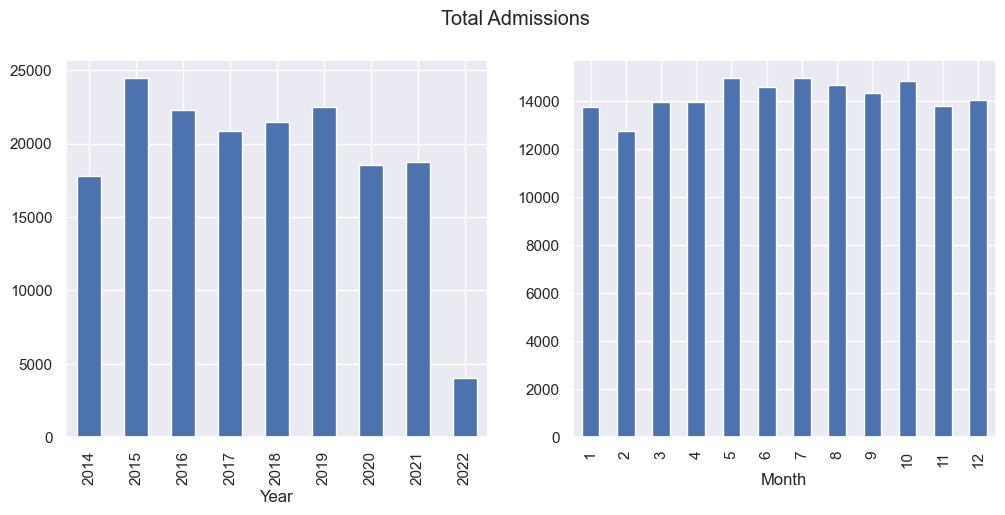

In [9]:
total_admissions(sci, start="2014-01-01", stop="2022-06-01")


In [10]:
def admissions_during_year(df: pd.DataFrame):
    year_min, year_max = (
        df.AdmissionDateTime.dt.year.min(),
        df.AdmissionDateTime.dt.year.max(),
    )

    df = (
        df.groupby(
            [df.AdmissionDateTime.dt.year, df.AdmissionDateTime.dt.isocalendar().week]
        )
        .size()
        .drop(53, level=1)
    )

    try:
        df.loc[year_min, 52] += df.loc[year_min, 1]
        df.loc[year_max, 1] += df.loc[year_max, 52]
        df.loc[year_min, 1], df.loc[year_max, 52] = np.nan, np.nan
    except KeyError:
        pass

    df = df.rolling(4).sum()  # .unstack(level=0)

    df = df.to_frame(name="Admissions").reset_index()
    sns_multi_time_series(
        df,
        "week",
        "Admissions",
        "AdmissionDateTime",
        xlabel="Week",
        ylabel="Admissions",
        title=f"Monthly total admissions (rolling) per year",
    )

    # ax = sns.lineplot(data=df[years])
    # ax.set(
    #     xlabel="Week",
    #     ylabel="Admissions",
    #     title=f"Monthly admissions (rolling) during {min(years)} - {max(years)}",
    # )
    # ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)

    # return ax


Most years exhibit a drop in admissions within the first 10 weeks of the year, but the rest of the year does not follow a uniform trend. 

Most notable is the plummet in admissions from W5-2020 followed by local peak in W30-2020. This, however, only reached the *minimum* admissions from the previous year. 2021 exhibits a contrasting spike in admissions from W10-W25 followed by subsequent drop to the lows of 2020, which extends into Q1-2022.

In [11]:
admissions_during_year(sci)


In [12]:
def quarterly_admissions_rolling(df: pd.DataFrame):
    return (
        df.groupby(df.AdmissionDateTime.dt.to_period("M"))
        .size()
        .rolling(4)
        .sum()
        .plot(
            xlabel="Year",
            ylabel="Admissions",
            title="Quarterly total admissions (rolling)",
            figsize=Notebook().FIGSIZE_SMALL,
        )
    )


The volatility in admissions is best visualised by the quarterly rolling sum. They currently sit at an all-time low.

In [13]:
quarterly_admissions_rolling(sci)


<AxesSubplot:title={'center':'Quarterly total admissions (rolling)'}, xlabel='Year', ylabel='Admissions'>

In [14]:
def elective_admissions_proportion_yearly(df: pd.DataFrame):
    df = df.groupby([df.AdmissionDateTime.dt.year, df.ElectiveAdmission]).size()
    df = df.xs(True, level=1) / df.sum(level=0)

    ax = (df * 100).plot.bar(
        xlabel="Year", ylabel="Elective Admissions (%)", figsize=Notebook.FIGSIZE_SMALL
    )
    ax.set(title="Proportion of elective admissions per year")


The SCI dataset is heavily biased against elective admissions (compared to the AD dataset, at least) and contains mostly emergencies. Interestingly, the proportion of elective admissions increases year-upon-year. 
Possibly an outcome of selection bias.

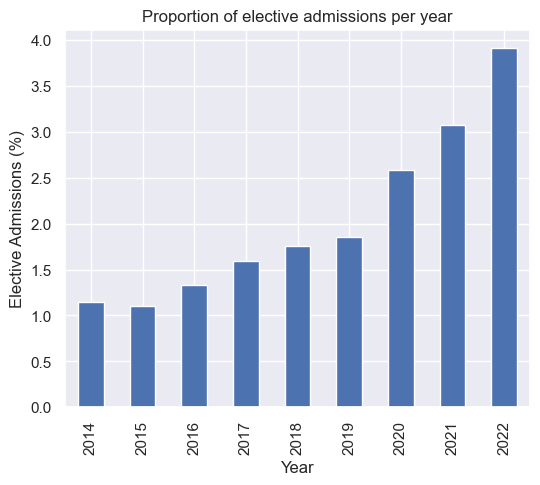

In [15]:
elective_admissions_proportion_yearly(sci)


## Age Statistics

Age bands do not exhibit any obvious trend or periodicity, only fluctuations. Proportion visibly tracks with age band, with 80+ making up the highest proportion of patients in the dataset.

In [16]:
band_proportions_periodic(
    sci,
    "AgeBand",
    title="Proportion of total admissions per age band, per quarter (rolling)",
)


## Mortality

In [17]:
def derive_mortality_band(df):
    df = df[['DiedDuringStay', 'DiedWithin30Days']].copy()
    df['DidNotDie'] = (~df.any(axis=1))
    return df.dot(df.columns)

sci['MortalityBand'] = derive_mortality_band(sci)

The vast majority (93.4%) of spells do not lead to mortality, either during stay or within 30 days of discharge.

In [18]:
sci.MortalityBand.value_counts()/sci.shape[0]*100

DidNotDie           93.386233
DiedDuringStay       3.809329
DiedWithin30Days     2.804439
Name: MortalityBand, dtype: float64

There are spikes in mortality during hospitalisation, as well as smaller spikes 30 days after discharge, that coincide with the COVID-19 peaks in early 2020 and early 2021. There is an ongoing spike as of Q1 2022.

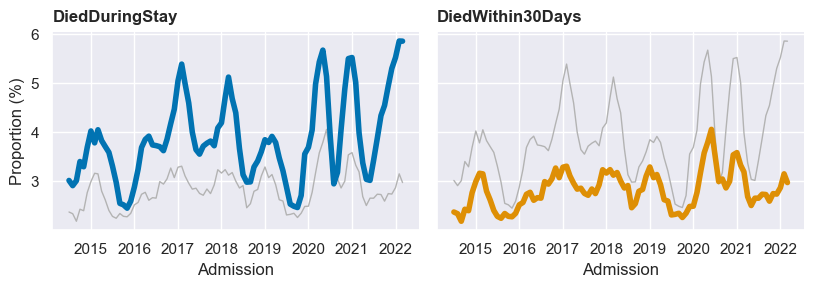

In [19]:
band_proportions_periodic(sci, 'MortalityBand', subset=['DiedDuringStay', 'DiedWithin30Days'])

## ICD-10 Statistics

In [20]:
def diag_topn_monthly(df, col, since=2019, topn=9, topn_since=2019, title="", graphing_function = band_proportions_periodic):
    df = df[df.AdmissionDateTime.dt.year >= since].copy()

    top_groups = (
        df[df.AdmissionDateTime.dt.year > topn_since][col]
        .value_counts()
        .nlargest(topn)
        .index
    )

    g = graphing_function(
        df,
        col,
        subset=top_groups,
        title=title or f"Top {topn} ICD-10 groups by proportion since {since}",
    )
    g.axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
    g.axes[0].set_xticks(g.axes[0].get_xticks()[::2])

    return g

def icd10_topn_monthly(df, since=2019, topn=9, topn_since=2019, title="", graphing_function=band_proportions_periodic):
    df["Group_Label"] = df.Group_Code + " " + df.Group_Desc.str[:27] + "..."
    return diag_topn_monthly(df, "Group_Label", since, topn, topn_since, title, graphing_function)

ICD-10 is segmented into broad *chapters* and finer *groups* of conditions. 

COVID-19 is coded as:
 - `U07.1`: COVID-19, virus identified
 - `J12.8`: Other viral pneumonia
 - `B97.2`: Coronavirus as the cause of diseases classified to other chapters

The start of the pandemic corresponds with a spike in `J09-J18`, however the same group exhibits spikes with a periodicity of 1 year, potentially annual seasonal outbreaks of influenza and other RIs. This has been less pronounced since 2020. The expected spike in Q4-2020, Q1-2021 was overshadowed by the spike in the (newly introduced) `U07.1` code for COVID.

`R00-R09`, which exhibits high proportion across all years, is a broad category of generic respiratory and circulatory symptoms. Its high prevalence is mostly fueled by generic "Chest Pain", "Dyspnoia", and related symptoms.

`J40-J47`, which indicates chronic respiratory diseas, exhibits spikes in early 2020 and mid-2021 fueled by `J44` - Chronic OBD with acute respiratory infection or exacerbation. However, these peaks are in-line with ones exhibited prior to COVID (see `since=2017`).

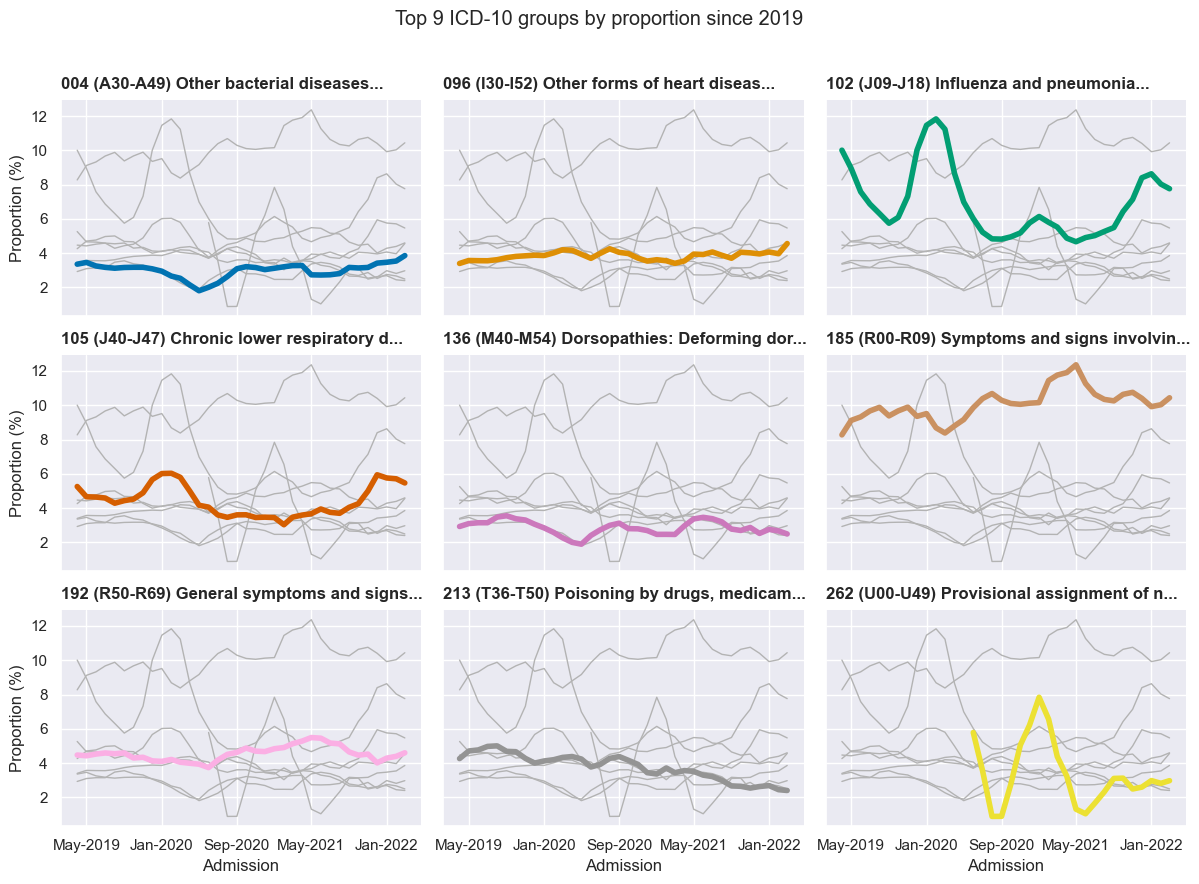

In [21]:
icd10_topn_monthly(sci, since=2019)


 - `R51`: Headache
 - `R07`: Pain in throat and chest
 - `J44`: Other chronic obstructive pulmonary disease
    - `J45`: Asthma
 - `J18`: Pneumonia, organism unspecified
 - `I50`: Heart failure
    - `I48`: Atrial fibrillation and flutter

In [22]:
topn_icd_in_year(sci, icd10, "2020-01-01", "2022-06-01")


In [23]:
def covid_over_time(df):
    covid_mask = df.MainICD10_3_Code == "U07"
    year_mask = df.AdmissionDateTime.dt.year >= 2020
    print(
        f"Total COVID-19: {covid_mask.sum()}/{df.shape[0]} -> {round(covid_mask.sum()/df.shape[0] * 100, 3)}%"
    )
    print(
        f"COVID-19 since 2020: {(year_mask & covid_mask).sum()}/{year_mask.sum()} -> {round((year_mask & covid_mask).sum()/year_mask.sum()*100, 3)}%"
    )
    return (
        df[covid_mask]
        .groupby(df[covid_mask].AdmissionDateTime.dt.to_period("W"))
        .size()
        .rolling(4)
        .sum()
        .plot(
            title="Admissions with U07 (Covid-19) as primary diagnosis",
            figsize=Notebook.FIGSIZE_SMALL,
        )
    )



Only 1323 of records (0.71%) have COVID-19 as the main diagnosis. This represents 0.775% of total admissions on record and 3.204% of admissions since 01-Jan-2020. 


Total COVID-19: 1323/170765 -> 0.775%
COVID-19 since 2020: 1323/41295 -> 3.204%


<AxesSubplot:title={'center':'Admissions with U07 (Covid-19) as primary diagnosis'}, xlabel='AdmissionDateTime'>

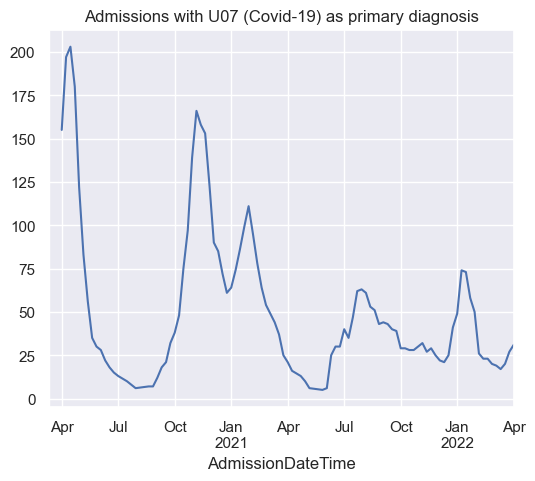

In [24]:
covid_over_time(sci)


The mortality of diagnostic groupings fluctuates but does not trend any particulary way (except COVID-19).

In [25]:
icd10_topn_monthly(sci[sci.MortalityBand != 'DidNotDie'].copy(), title="Top 9 ICD-10 groups with mortality by proportion since 2019")

### Birkmeyer Subset

Birkmeyer20 provides a set of ICD-10 codes that represent "the twenty top medical conditions responsible for admissions to hospital medicine practices". These codes making up each condition can come from various ICD-10 groupings or chapters. 

The ICD-10 codes acquired directly from the published paper do not match our set of codes precisely. We use the closest match instead. 

In [26]:
def birk_topn_monthly(df, since=2019, topn=9, topn_since=2019):
    df = df.copy()
    len_mask = df['MedicalCondition'].str.len() > 44
    df.loc[len_mask, 'MedicalCondition'] = df.loc[len_mask, 'MedicalCondition'].str[:41]+'...'
    return diag_topn_monthly(df, col='MedicalCondition', since=since, topn=topn, topn_since=topn_since)



In [27]:
birk_topn_monthly(sci_birk)

## LOS Statistics

Total LOS has trended upwards over time, with the overall median showing a highly volatile upward trajectory. The banded LOS indicates a gradual rise in stays over 72 hours long, with a weak annual periodicity, though this is less evident in the rarer bands of 21-36 or 36-48. Correspondingly, 12-24 hour spells are trending downwards.

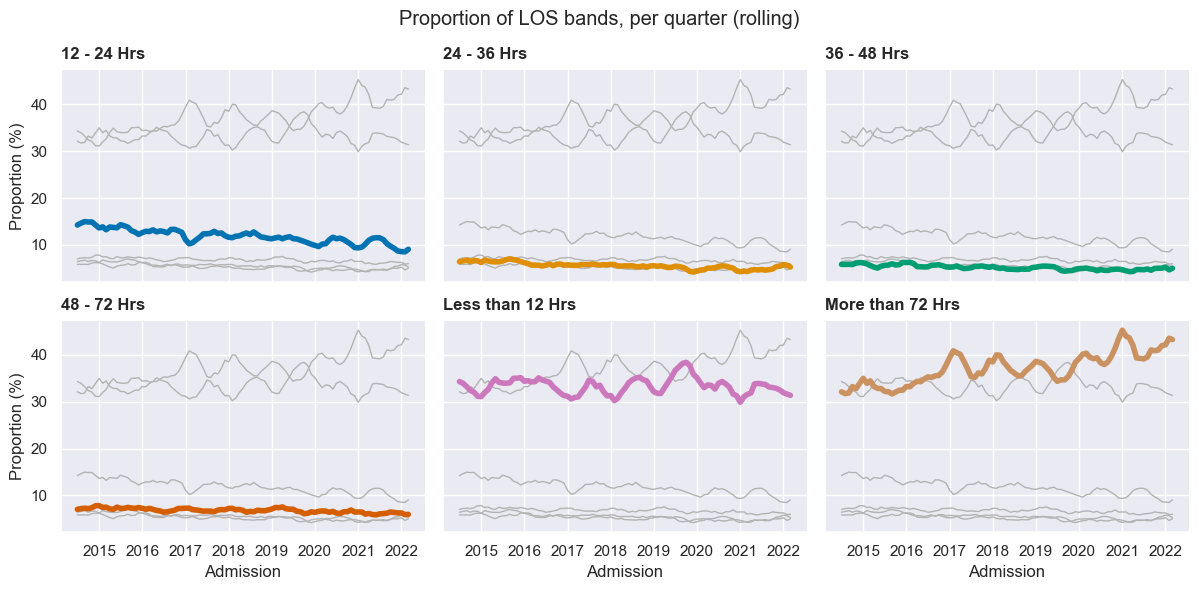

In [28]:
band_proportions_periodic(
    sci[sci.LOSBand != "Still In"],
    "LOSBand",
    "Proportion of LOS bands, per quarter (rolling)",
)


In [29]:
def median_los_quarterly(df: pd.DataFrame):
    return (
        df.groupby(df.AdmissionDateTime.dt.to_period("W"))
        .TotalLOS.mean()
        .rolling(4)
        .median()
        .plot(
            title="Median total LOS per month (rolling)", figsize=Notebook.FIGSIZE_SMALL
        )
    )



In [30]:
median_los_quarterly(sci)


<AxesSubplot:title={'center':'Median total LOS per month (rolling)'}, xlabel='AdmissionDateTime'>

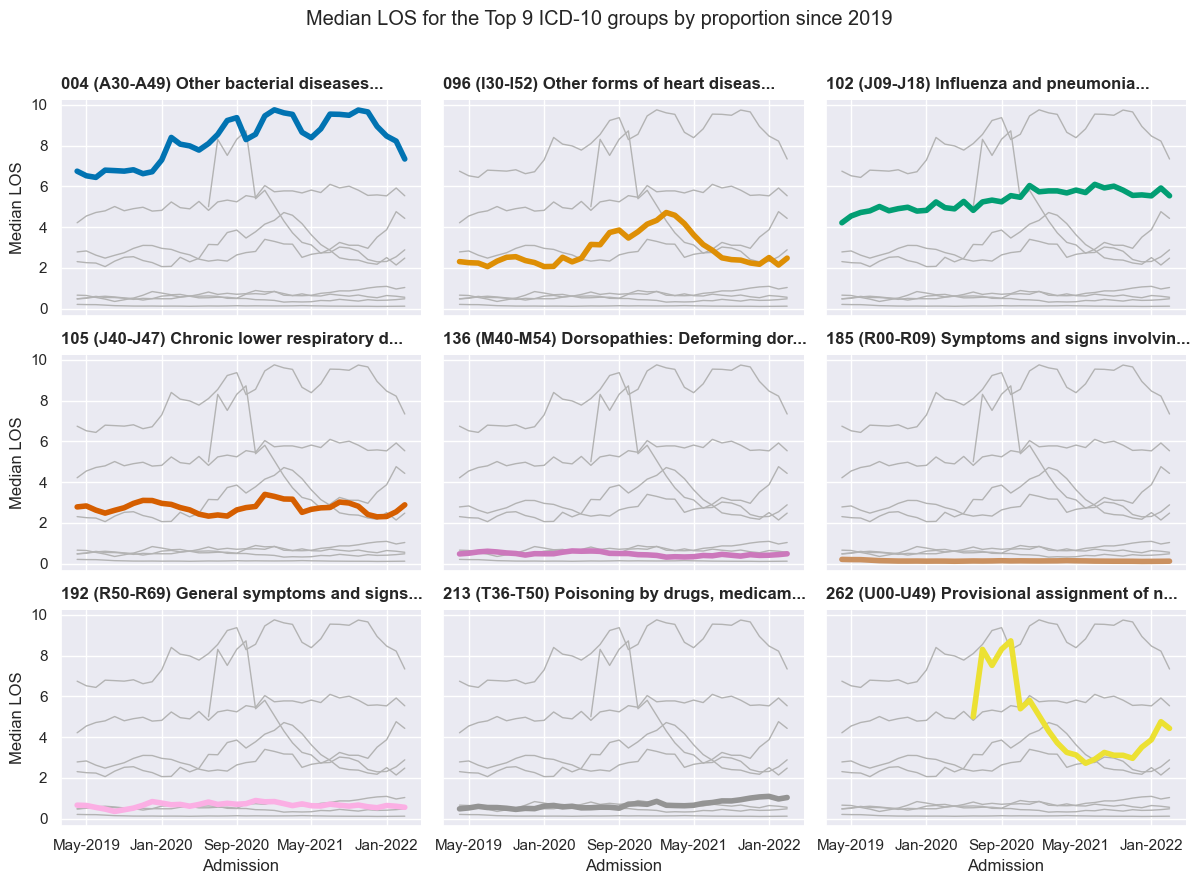

In [31]:
icd10_topn_monthly(sci, graphing_function=median_los_per_band, title="Median LOS for the Top 9 ICD-10 groups by proportion since 2019")

In [32]:
median_los_per_band(sci, "MortalityBand")

## Missing Data

Almost all entires include the essential information of admission/discharge dates, age, ICD-10 and OPCS codes. A majority of entries have a NEWS score and associated parameters used to calculate it. The lowest proportion of entries have full blood test results including Sodium, Urea, Venous PH and pO2.

In [33]:
def missing_data(df, subset=[], title="Proportion of missing values per column"):
    if len(subset):
        df = df[subset]
    top_groups = df.groupby(df.Group_Code).size().nlargest(4).index
    missing = df.set_index(df.Group_Code).loc[top_groups]
    missing = missing.isna().sum(axis=0) / missing.shape[0]
    missing = missing[missing > 0].sort_values().to_frame(name="Missing values (%)")

    ax = sns.barplot(data=missing * 100, x="Missing values (%)", y=missing.index)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.set(ylabel="Column", title=title)


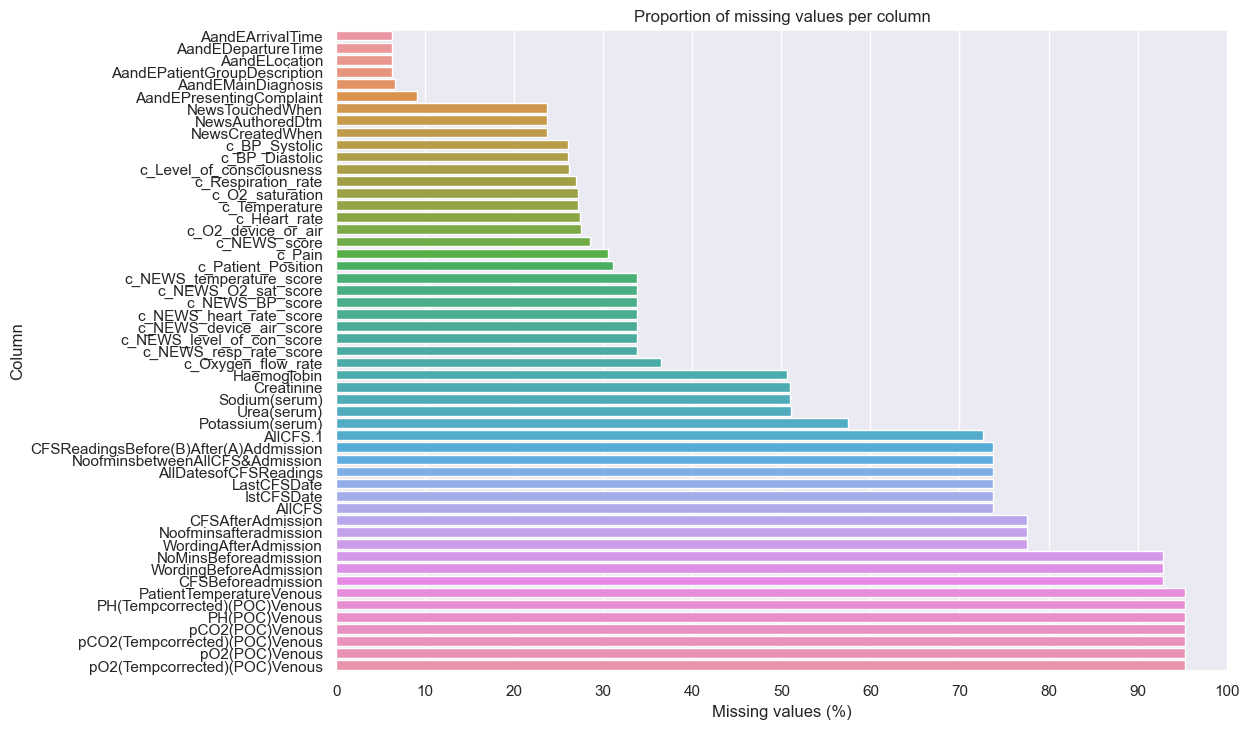

In [34]:
missing_data(sci, sci_subset)


The subset of entries with NEWS and Haemoglobin/Creatinine/etc is similarly distributed in terms of ICD-10 to the rest of the dataset.

In [35]:
topn_icd_in_year(
    sci[
        sci[
            [
                "c_NEWS_score",
                "Haemoglobin",
                "Creatinine",
                "Sodium(serum)",
                "Urea(serum)",
            ]
        ]
        .notna()
        .all(1)
    ],
    icd10,
    "2020-01-01",
    "2022-06-01",
    title="Top 5 ICD-10 groups with NEWS score present",
)


The top 5 ICD-10 groups that have *no* missing values include 
 - `U07`: COVID-19
 - `T39`: Poisoning by nonopioid analgesics, antipyretics, antirheumatics
 - `J44`: Chronic obstructive pulmonary disease
 - `J18`: Pneumonia (organism unspecified)
 - `A41`: Sepsis due to bacterial infection

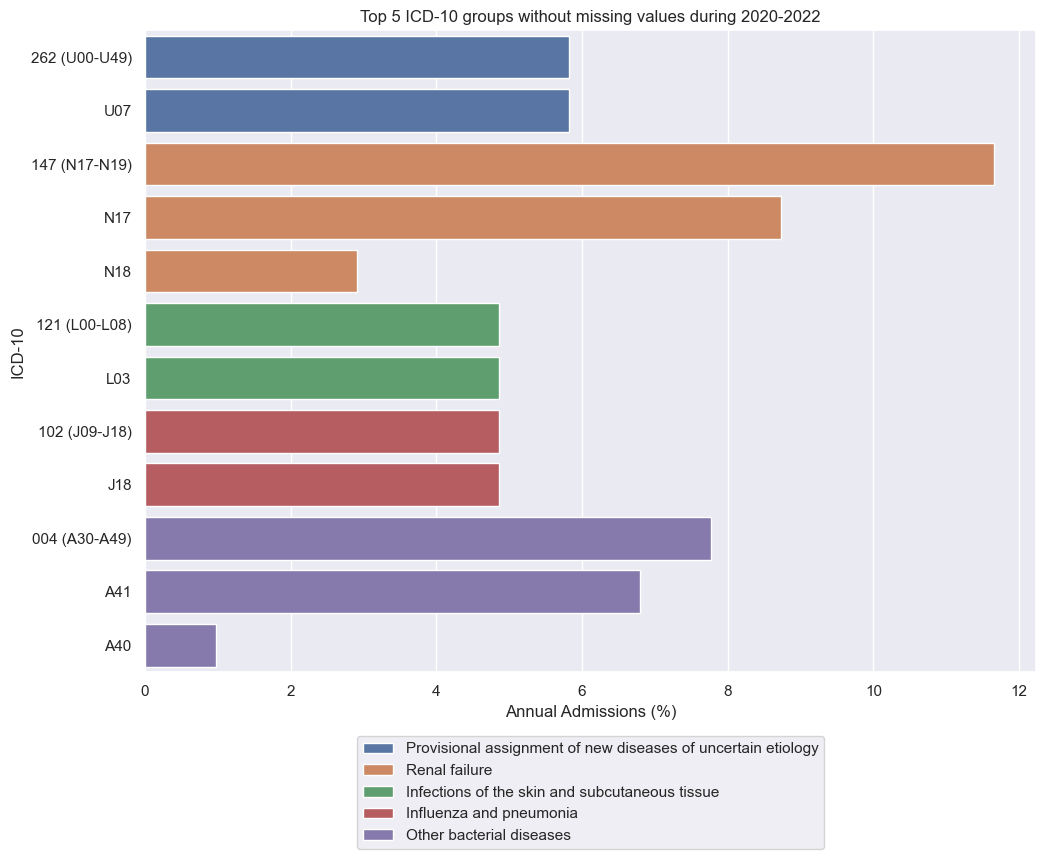

In [36]:
topn_icd_in_year(
    sci[sci[sci.isna().sum().nlargest(5).index].notna().all(1)],
    icd10,
    "2020-01-01",
    "2022-06-01",
    title="Top 5 ICD-10 groups without missing values during 2020-2022",
)


Entries from 2020 onwards have less missing data overall, though still ~80% lack venous data.

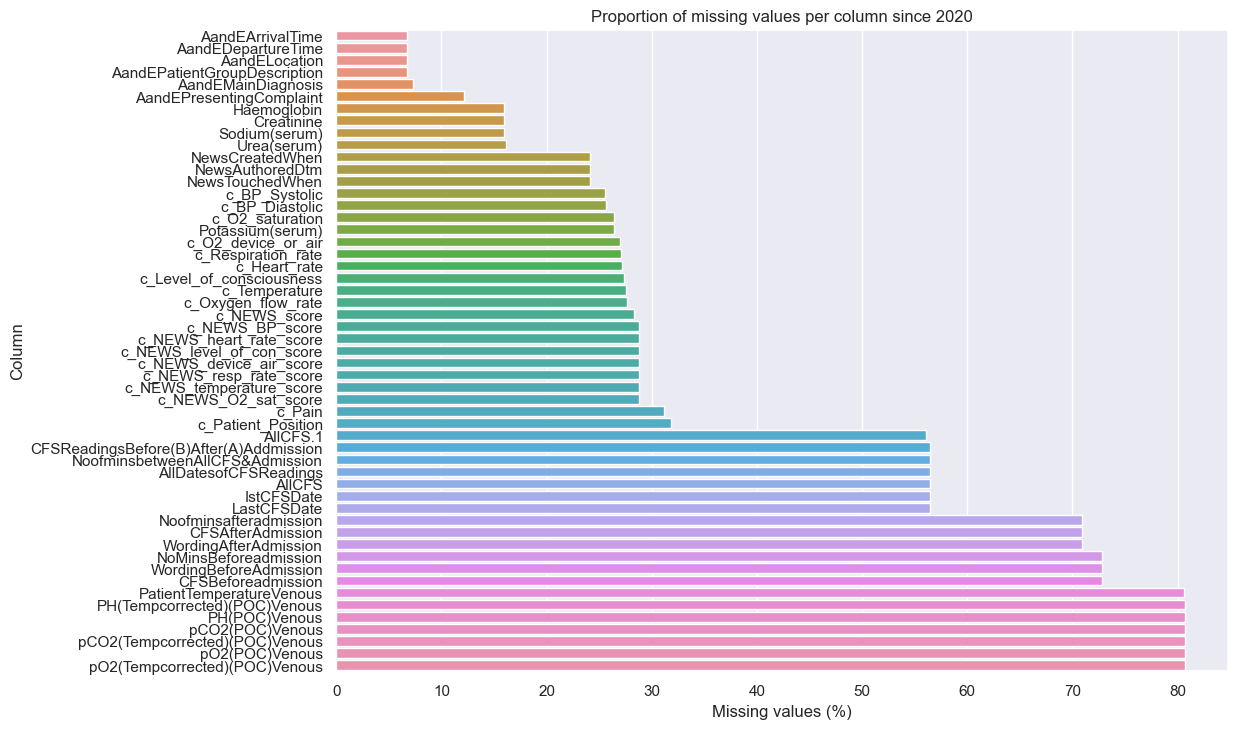

In [37]:
missing_data(
    sci[sci.AdmissionDateTime.dt.year >= 2020],
    subset = sci_subset,
    title = "Proportion of missing values per column since 2020",
)



# AD Dataset

In [38]:
ad_dialysis_mask = ~((ad.MainICD10 == "N18.5") & (ad.MainOPCS4 == "X40.3"))
ad_masked = ad[ad_dialysis_mask].copy()

## Admission Statistics

In [39]:
print(f"Total Entries: {ad.shape[0]}")


Total Entries: 1164549


AD contains 1164549 patient records from Q2-2013 to Q1-2021 inclusive. These are more heavily tailed in the earlier years (up to 2019) and somewhat higher during the winter months.

array([<AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Month'>],
      dtype=object)

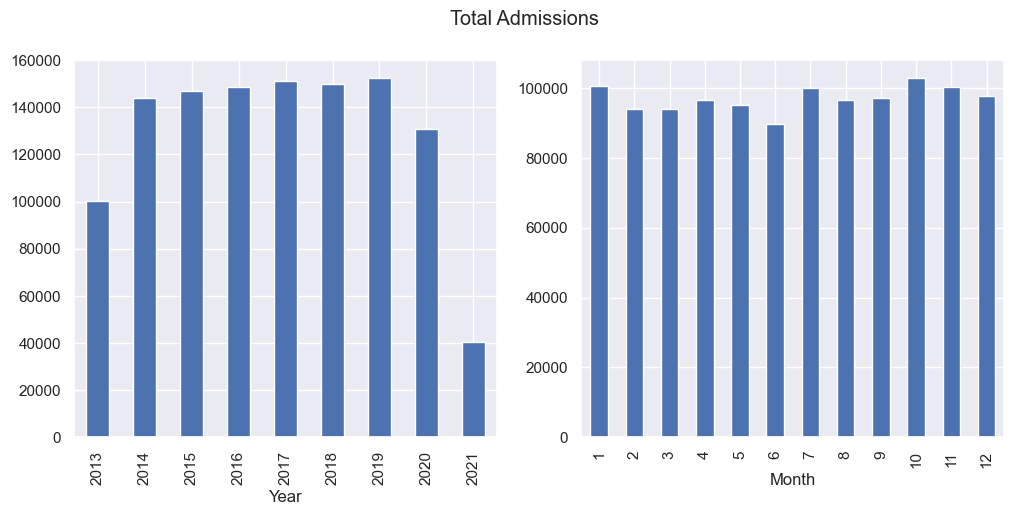

In [40]:
total_admissions(ad, start="2013-01-01", stop="2021-06-01")


When filtering out dialysis, the periodicity over months of the year is more pronounced. However, since they are mostly flat year-upon-year, the annual proportions do not change much by filtering them out.

array([<AxesSubplot:xlabel='Year'>, <AxesSubplot:xlabel='Month'>],
      dtype=object)

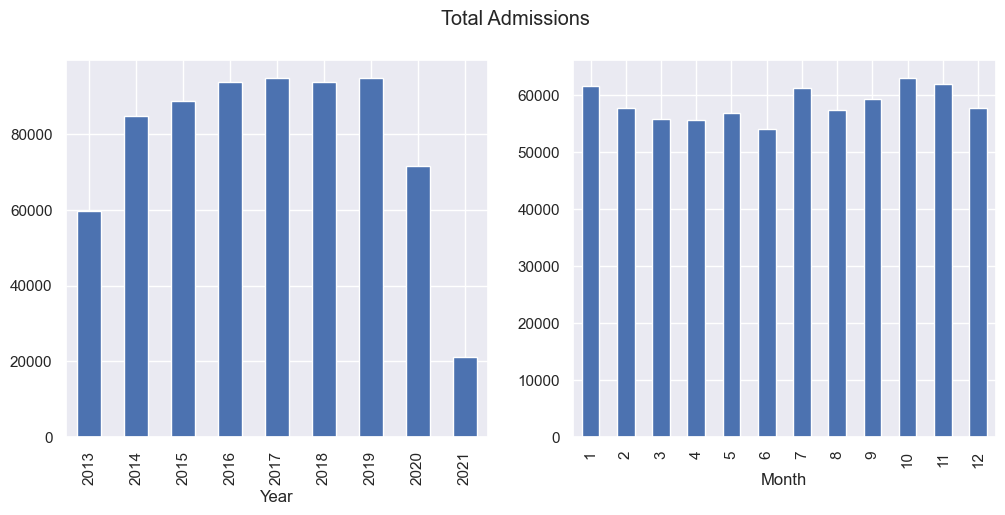

In [41]:
total_admissions(ad_masked, start="2013-01-01", stop="2021-06-01")

Most years exhibit a drop in admissions within the first 10 weeks of the year and gradual increase towards the end of the year.

Admissions (in this dataset) have been increasing year-on-year from 2013-2020. 

Most notable is the plummet in admissions from W5-2020, bottoming out in W25-2020, followed by local peak in W50-2020. This local peak has approached the levels of 2013.

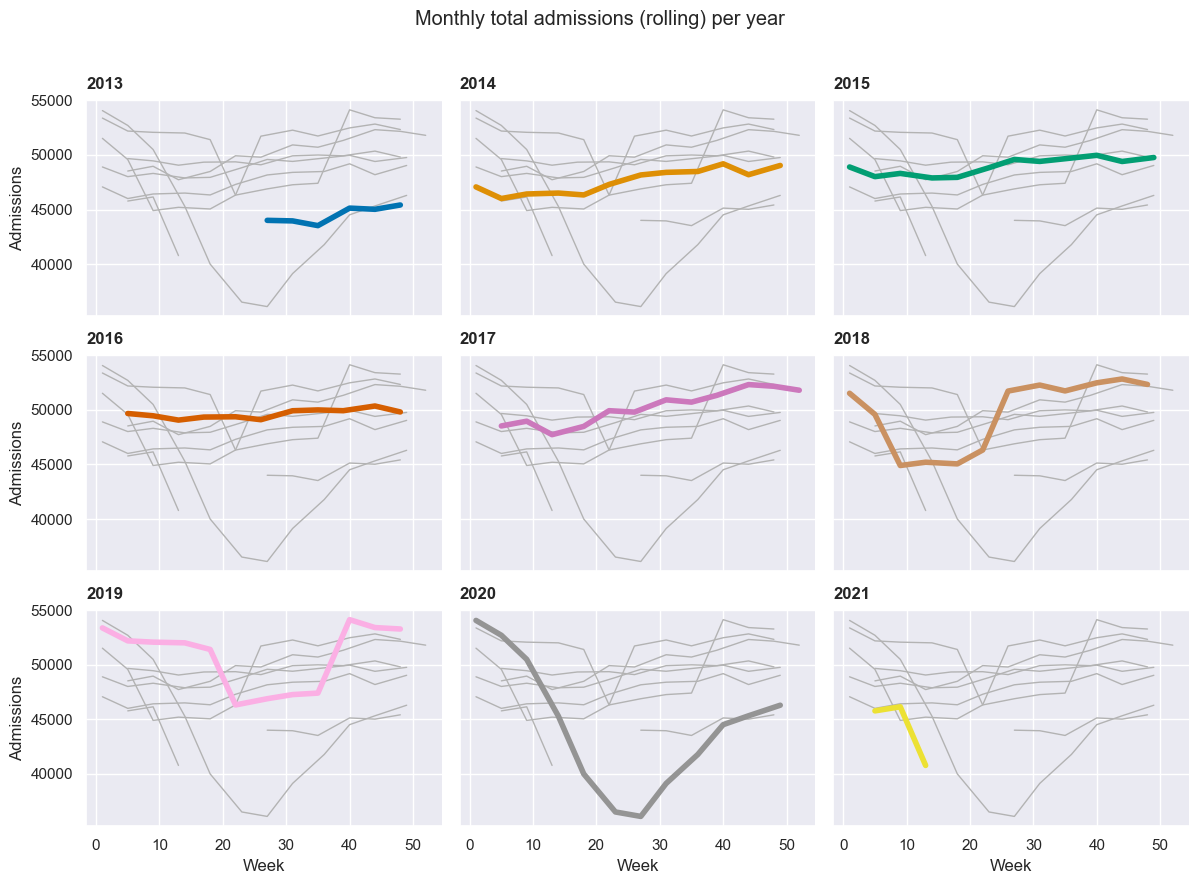

In [42]:
admissions_during_year(ad)


The gradual increase and subsequent plummet are most visible when looking at quarterly totals.

<AxesSubplot:title={'center':'Quarterly total admissions (rolling)'}, xlabel='Year', ylabel='Admissions'>

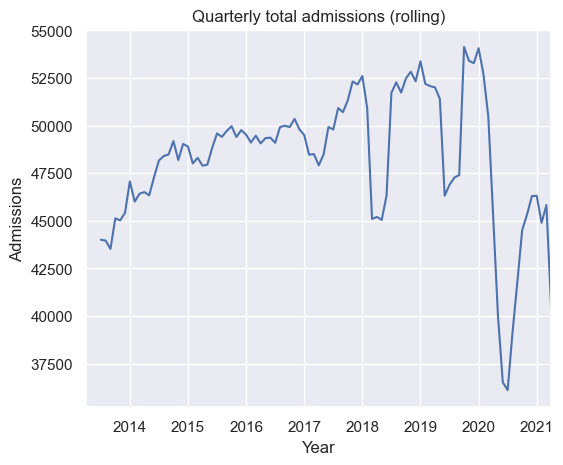

In [43]:
quarterly_admissions_rolling(ad)


The majority of admissions in this dataset are elective. The proportion of these fluctuates over time, but not significantly.

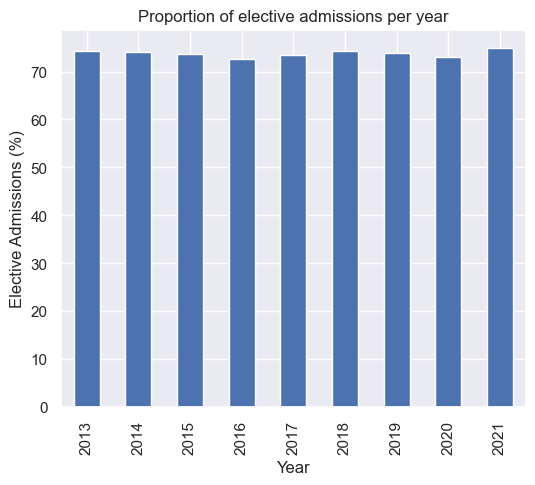

In [44]:
elective_admissions_proportion_yearly(ad)


Filtering out dialysis shows a more pronounced drop in elective admissions in 2020. However, electives still make up over 50% of admissions.

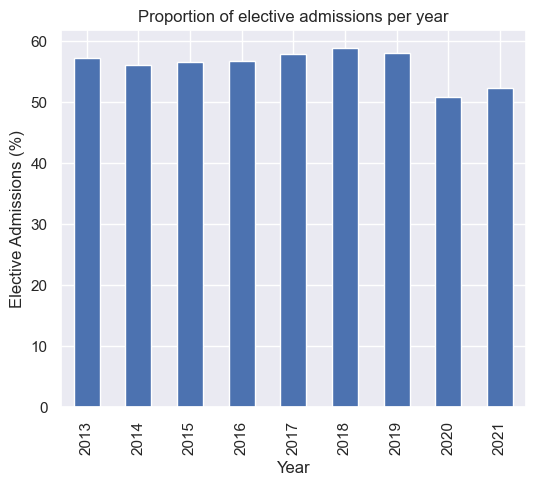

In [45]:
elective_admissions_proportion_yearly(ad_masked)

## Age Statistics

Admissions in this dataset are dominated by adults 30-79 years old. 

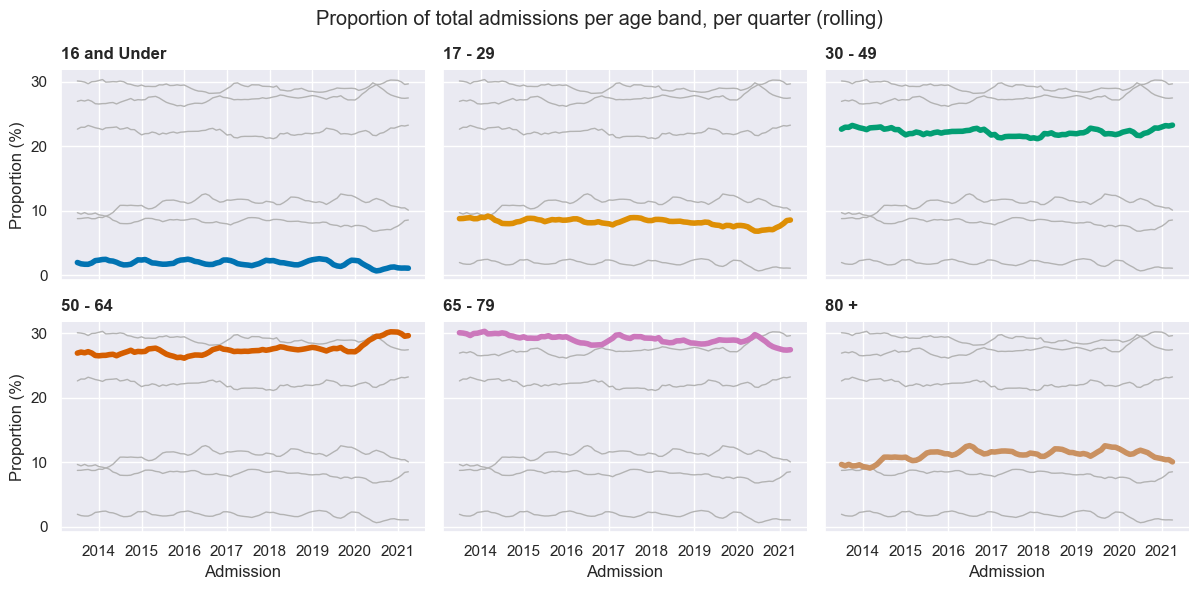

In [46]:
band_proportions_periodic(
    ad,
    "AgeBand",
    title="Proportion of total admissions per age band, per quarter (rolling)",
)


There are higher proportion of very young people, as well as very old adults, when filtering for only non-elective admissions.

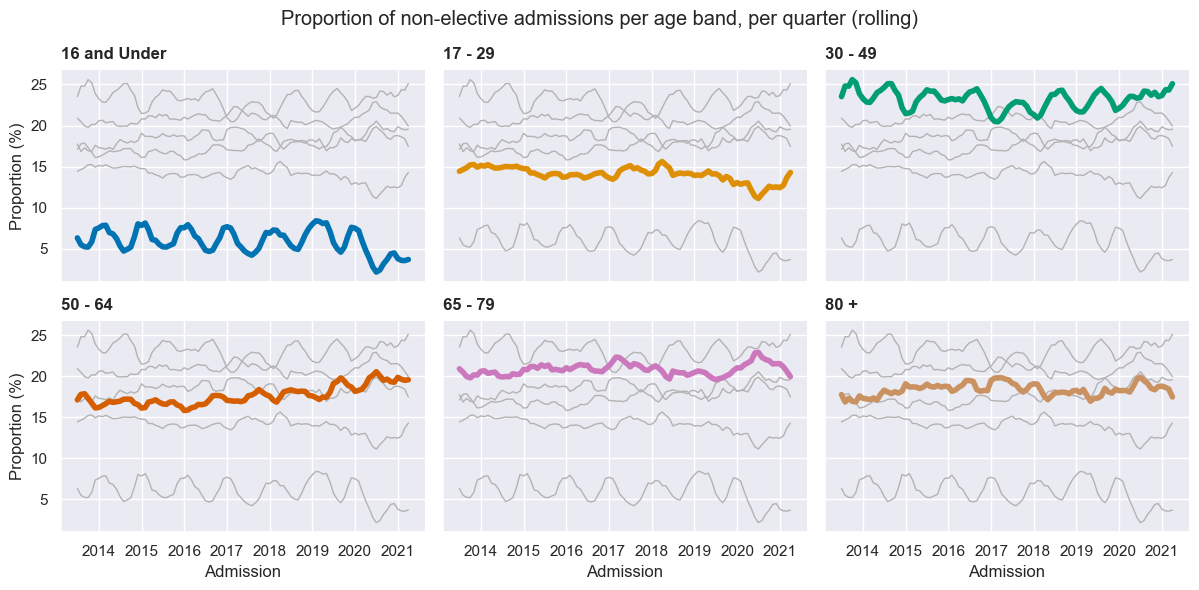

In [47]:
band_proportions_periodic(
    ad[~ad.ElectiveAdmission],
    "AgeBand",
    title="Proportion of non-elective admissions per age band, per quarter (rolling)",
)


Filtering out admissions there for chronic kidney conditions (dialysis) but keeping all other gives similar proportions to initial plots.

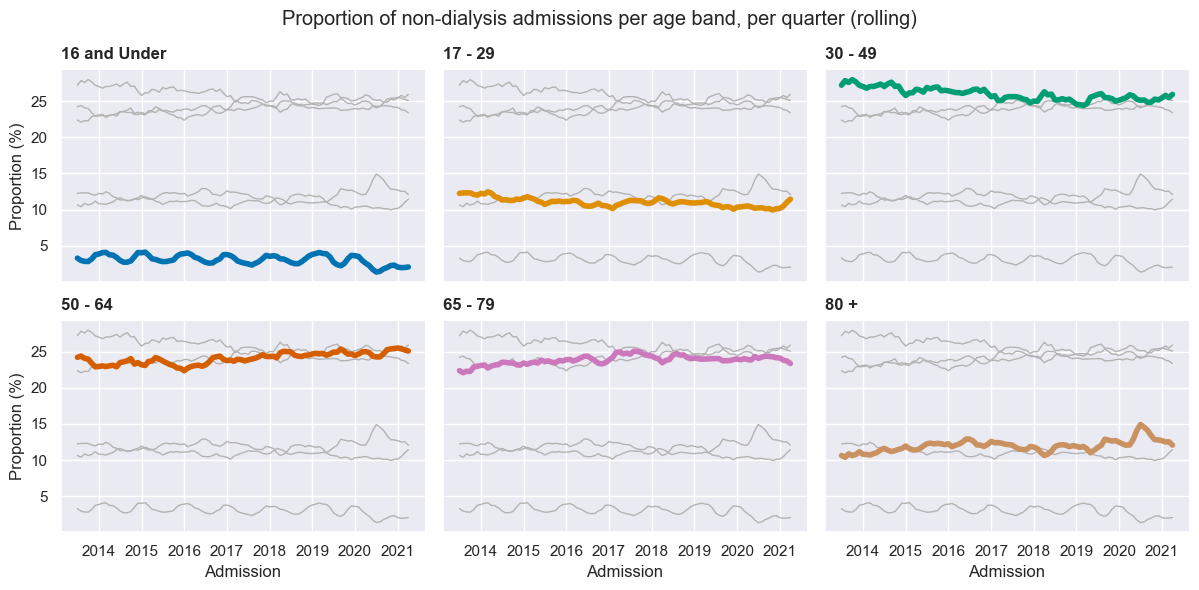

In [48]:
band_proportions_periodic(
    ad_masked,
    "AgeBand",
    title="Proportion of non-dialysis admissions per age band, per quarter (rolling)",
)


## Mortality

In [52]:
ad['MortalityBand'] = derive_mortality_band(ad)
ad_masked['MortalityBand'] = derive_mortality_band(ad_masked)

The vast majority (98%) of admissions did not result in mortality. Filtering out dialysis admissions only drops it to 97.5%.

In [50]:
ad.MortalityBand.value_counts()/ad.shape[0]*100

DidNotDie           98.020779
DiedWithin30Days     1.083595
DiedDuringStay       0.895626
Name: MortalityBand, dtype: float64

In [53]:
ad_masked.MortalityBand.value_counts()/ad_masked.shape[0]*100

DidNotDie           97.420741
DiedDuringStay       1.477055
DiedWithin30Days     1.102204
Name: MortalityBand, dtype: float64

There are spikes on mortality that once again coincide with COVID peaks. Unlike SCI, mortality within 30 days is more pronounced.

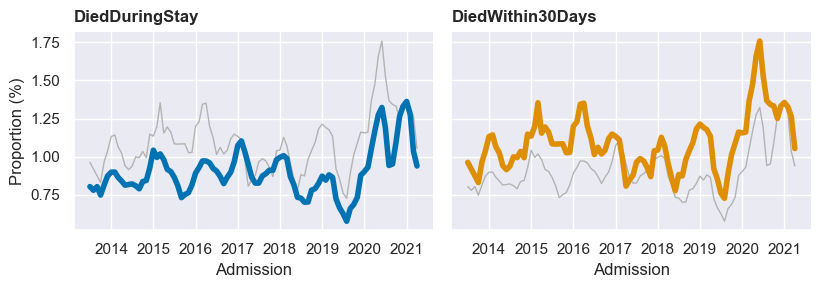

In [54]:
band_proportions_periodic(ad, 'MortalityBand', subset=['DiedDuringStay', 'DiedWithin30Days'])

## ICD-10 Statistics

Admissions are dominated by far by `N18.5` - Chronic kidney disease. These are predominantly elective admissions of patients staying for Less than 12 Hrs for Dialysis (`X40.3`).

Admissions coded into "generic" bands such as `R00-R19` (Chest pain) or `R50-R69` (e.g., Headache, Other chronic pain, Syncope and collapse), as well as `K55-K64` (Other functional intestinal disorders, e.g. Constipation) see sharp dips at the start of the pandemic. There are correspondign spikes in the *proportion* of severe conditions (`C81-C96`, malignant neoplasms).

In [55]:
icd10_topn_monthly(
    ad_masked, since=2019
)



 - `R10`: Abdominal and pelvic pain
 - `R07`: Pain in throat and chest
 - `K50`: Crohn's disease [regional enteritis]
 - `I63`: Cerebral infarction
 - `G35`: Multiple sclerosis

In [56]:
topn_icd_in_year(ad_masked, icd10, "2020-01-01", "2022-06-01")



C:\Users\stybl\miniconda3\envs\py39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


COVID-19 diagnoses start after April 2020 and peak in January 2021. Only 1622 records (0.14%) have COVID as the main diagnosis (0.95% of admissions since 01-Jan-2020).

Total COVID-19: 1622/1164549 -> 0.139%
COVID-19 since 2020: 1622/171049 -> 0.948%


<AxesSubplot:title={'center':'Admissions with U07 (Covid-19) as primary diagnosis'}, xlabel='AdmissionDateTime'>

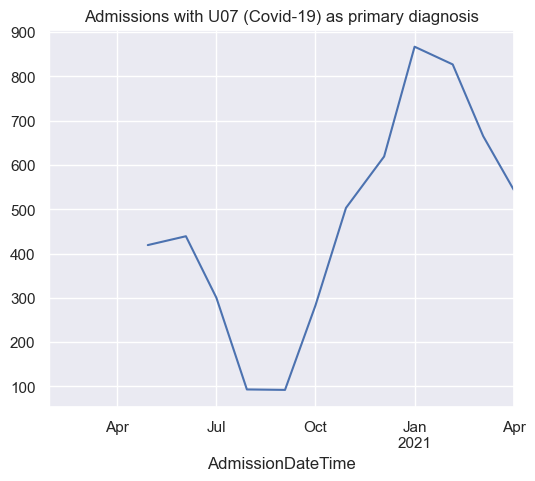

In [57]:
covid_over_time(ad)


The majority of mortalities are associated with chronic kidney disease. This may be an instance of selection bias, however.

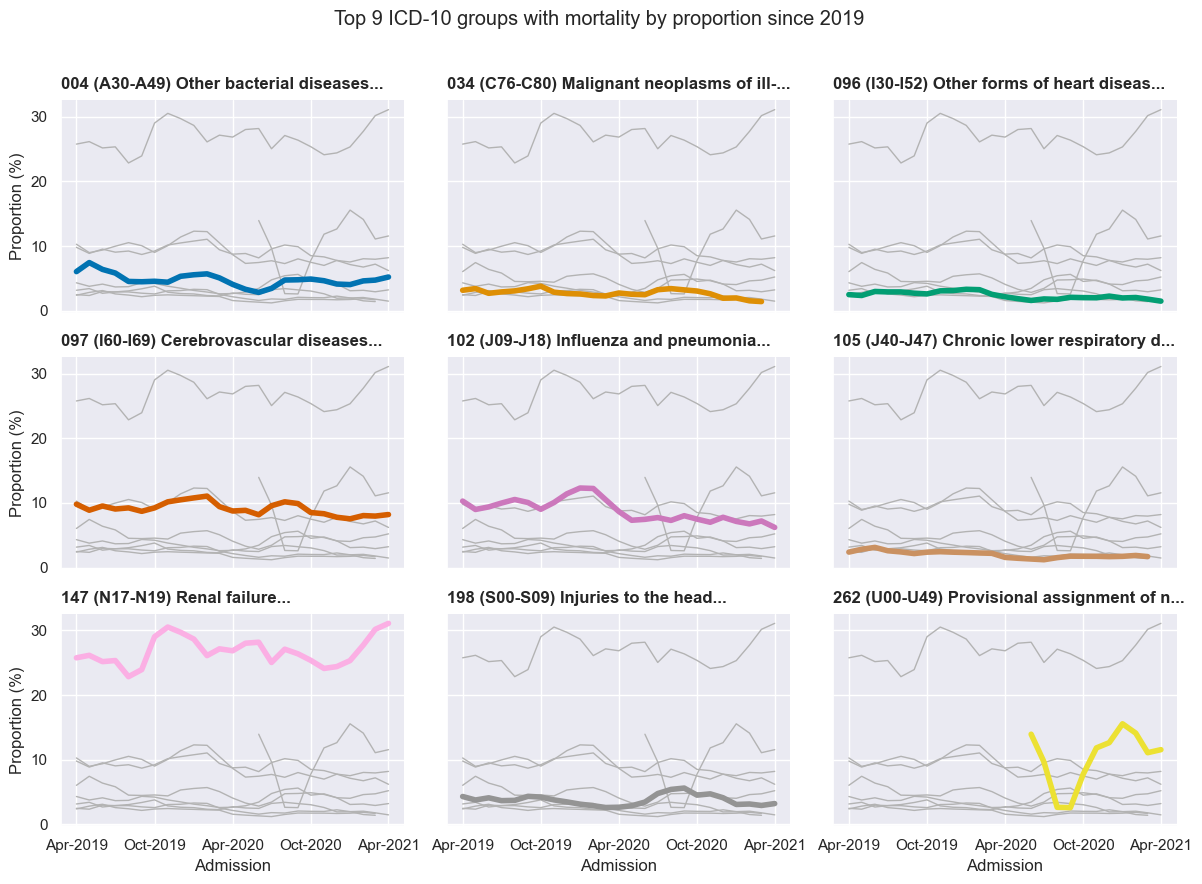

In [58]:
icd10_topn_monthly(ad[ad.MortalityBand != 'DidNotDie'].copy(), title="Top 9 ICD-10 groups with mortality by proportion since 2019")

Filtering out kidney disease reveals sharp spikes in COVID-19 mortality. It also reveals high overall proportions of mortality with Pneumonia and Cerebral infractions (`I63.9`, `I63.5`).

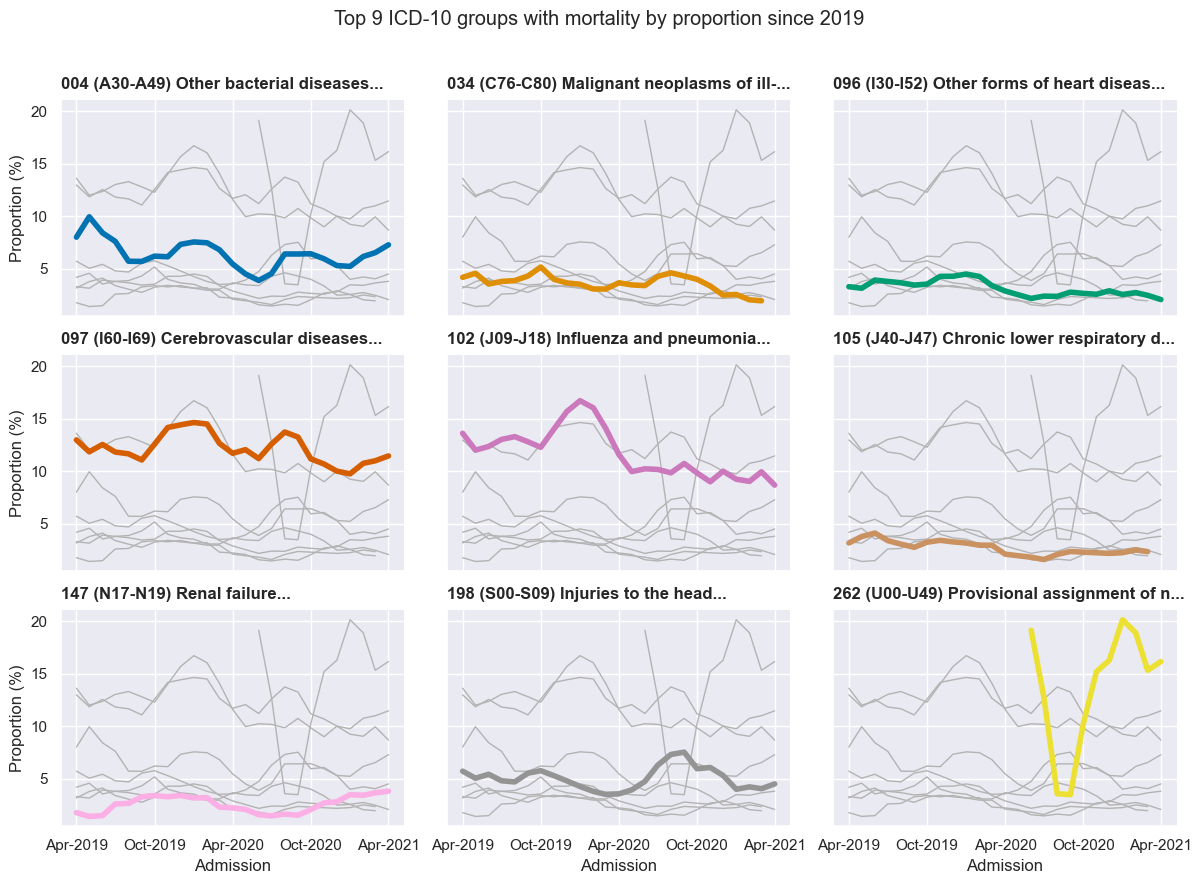

In [59]:
icd10_topn_monthly(ad_masked[ad_masked.MortalityBand != 'DidNotDie'].copy(), title="Top 9 ICD-10 groups with mortality by proportion since 2019")

### Birkmeyer Subset

Once again, diagnoses are dominated by far by chronic kidney disease. Filtering it out yields:

In [60]:
birk_topn_monthly(ad_birk[ad_birk.MainICD10 != 'N18.5'])

## LOS Statistics

LOS is dominated, by far, by spells `Less than 12 hours`. The plot below omits this category so that fluctuations in the remaining bands are visible.

In [61]:
band_proportions_periodic(
    ad[ad.LOSBand != "Less than 12 Hrs"],
    "LOSBand",
    "Proportion of LOS bands, per quarter (rolling)",
)


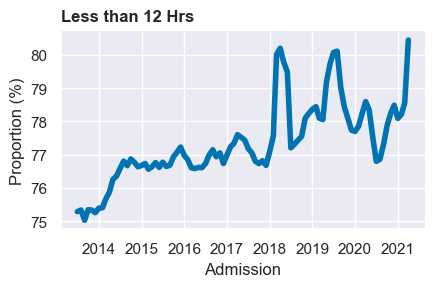

In [62]:
band_proportions_periodic(ad, "LOSBand", subset=["Less than 12 Hrs"])



The median total LOS has trended (shakily) upwards, before plummeting most recently. Generally, sharp dips coincide with spikes in Less than 12 hr stays.

In [63]:
median_los_quarterly(ad)


<AxesSubplot:title={'center':'Median total LOS per month (rolling)'}, xlabel='AdmissionDateTime'>

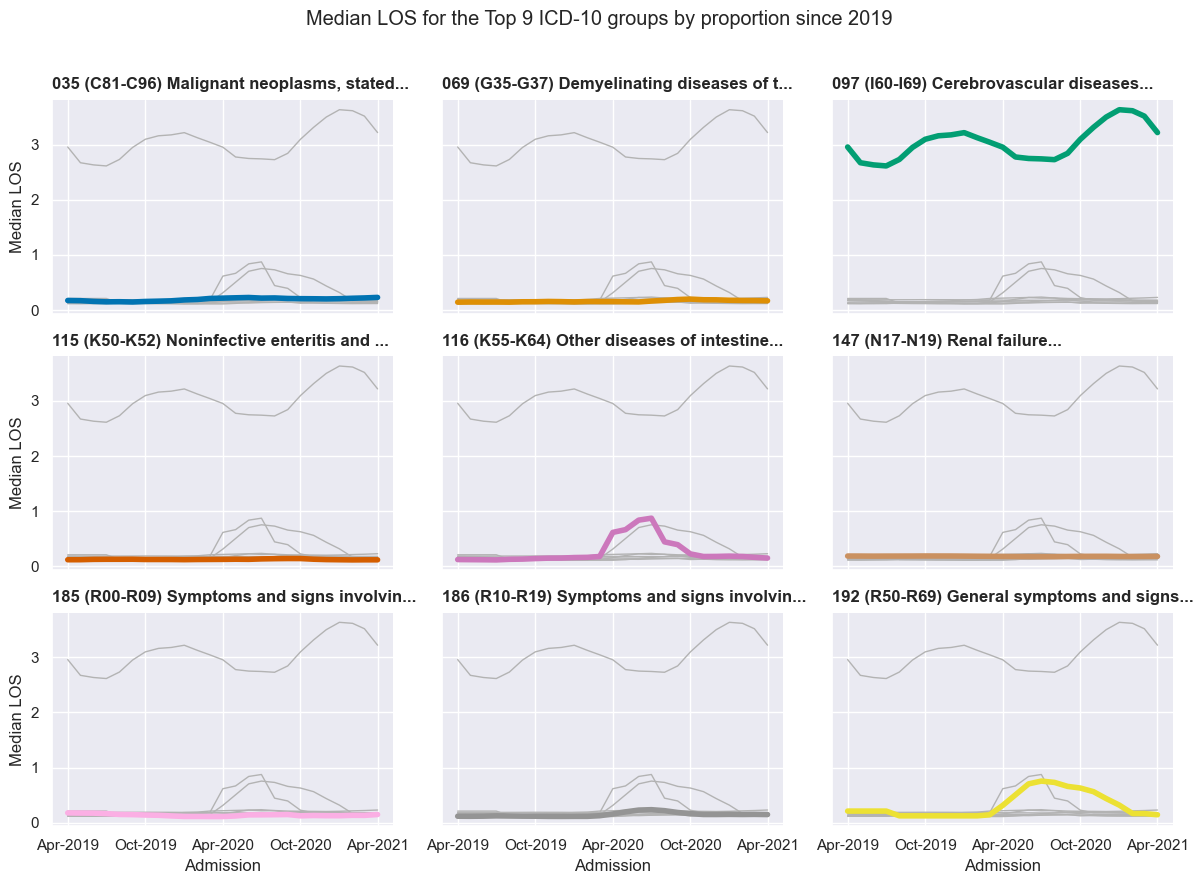

In [64]:
icd10_topn_monthly(ad, graphing_function=median_los_per_band, title="Median LOS for the Top 9 ICD-10 groups by proportion since 2019")

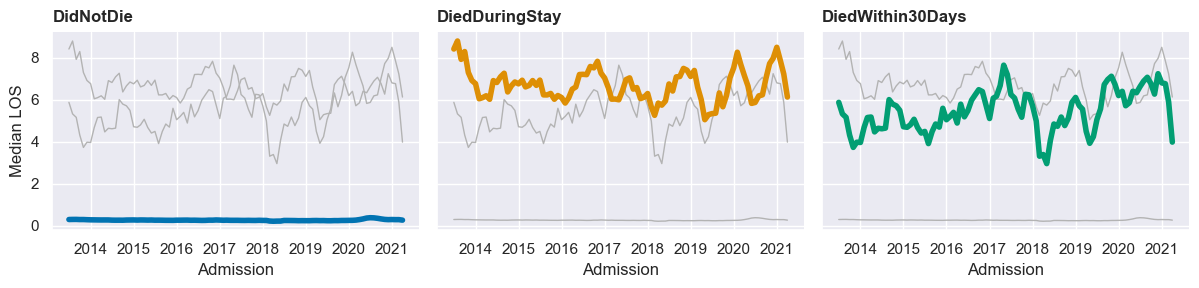

In [65]:
median_los_per_band(ad_masked, "MortalityBand")

## Missing Data

Missing data mostly takes the form of "optional" columns such as secondary ICD-10 diagnostic codes, secondary OPCS-4, and ward progression. Where these are not present, they can be assumed to not be applicable to the patient.

In [66]:
missing_data(ad)


This does not vary obviously over time.

In [67]:
missing_data(
    ad[ad.AdmissionDateTime.dt.year >= 2019],
    title = "Proportion of missing values per column since 2019",
)
